In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cobra
import os
os.getcwd()

from src.no_BayesianInference import BMCA, util

Generating data for running through the pipeline.

Running BMCA on BioModel 64

In [2]:
# load the Teusink model
ant_file = 'data/interim/Antimony/BIOMD0000000064_e.ant'
data_file = 'data/interim/generated_data/BIOMD0000000064_e_0.csv'
data = pd.read_csv(data_file)

Comparing flux values, original and perturbed

In [3]:
_ = data.transpose().sort_index()
_.rename({0: "unperturbed ss", 1: "EtOH -50%"}, axis=1, inplace=True)
_.loc['v_':'v_z']

,unperturbed ss,EtOH -50%
v_vADH,129.215909,129.215909
v_vALD,77.349527,77.349527
v_vATP,84.532764,84.532764
v_vENO,136.496807,136.496807
v_vG3PDH,18.202246,18.202246
v_vGAPDH,136.496807,136.496807
v_vGLK,88.149527,88.149527
v_vGLT,88.149527,88.149527
v_vGLYCO,6.000000,6.000000
v_vPDC,136.496807,136.496807


Calculating the steady state concentrations of the Teusink model when EtOH concentration is halved. 

In [4]:
s  = te.loada(ant_file)
# s.ETOH = s.ETOH/2
s.steadyState()
true_ss_values = pd.DataFrame(s.getFloatingSpeciesConcentrations(), index=s.getFloatingSpeciesIds(), columns=['true'])
true_ss_values.sort_index(inplace=True)
# s.getScaledFluxControlCoefficientMatrix()

Predicting the steady state concentration values 

In [5]:
s  = te.loada(ant_file)
BIOMD64 = BMCA.BMCA(ant_file, data_file, desired_product='ETOH')

BIOMD64 = BMCA.BMCA(ant_file, data_file, desired_product='ETOH')
chi_star = BIOMD64.calculate_Smallbone_ss(BIOMD64.Ex, BIOMD64.Ey)


In [6]:
BIOMD64.x_star

array([9.87586920e-02, 1.03324561e+00, 1.12812815e-01, 6.01907640e-01,
       7.77523537e-01, 3.29574000e-04, 3.56484038e-01, 4.48437110e-02,
       7.36168420e-02, 8.52315246e+00, 1.70114452e-01, 6.30888164e+00,
       1.54555977e+00, 4.44402330e-02])

In [7]:
x_ss = np.exp(chi_star.to_numpy())
a = s.getIndependentFloatingSpeciesIds()
b = s.getFloatingSpeciesIds()
squiggle_idx = [b.index(i) for i in a if i in b]
squiggle_idx.sort()
estimated_ss = pd.DataFrame(data=x_ss, index=[b[i] for i in squiggle_idx], columns=['estimated'])

In [8]:
comparison = pd.concat([true_ss_values, estimated_ss], axis = 1)
comparison['error (%)'] = (comparison['estimated'])/comparison['true']
comparison.sort_index()

,true,estimated,error (%)
ACE,0.170114,0.189530,1.114133
BPG,0.000330,0.015044,45.647210
F16P,0.601908,0.008905,0.014795
F6P,0.112813,0.037363,0.331192
G6P,1.033246,0.037087,0.035894
GLCi,0.098759,0.395924,4.009007
NAD,1.545560,0.951731,0.615784
NADH,0.044440,NaN,NaN
P,6.308882,0.236591,0.037501
P2G,0.044844,0.055296,1.233077


Plotting relative changes in EtOH by relative changes in steady state intracelluar metabolite concentrations (Figure 3 in Smallbone et al. )

In [36]:
EtOH_scale = np.logspace(-1, 1, num=22)[:-2]
EtOH_scale

array([0.1       , 0.12451971, 0.15505158, 0.19306977, 0.24040992,
       0.29935773, 0.37275937, 0.46415888, 0.57796929, 0.71968567,
       0.8961505 , 1.11588399, 1.38949549, 1.73019574, 2.15443469,
       2.6826958 , 3.34048498, 4.15956216, 5.17947468, 6.44946677])

In [47]:
def calculate_relative_change(metabolite): 
    metabolite_scale = []

    for change in EtOH_scale: 
        s.resetAll()
        s.ETOH =(change * s.ETOH)
        # print(s.ETOH)
        s.steadyState()
        
        #s.simulate(0,50)
        #s.plot(title=change)
        
        metabolite_scale.append(s.getValue(metabolite))

    # calculate the relative change in BPG
    s.resetAll()
    s.steadyState()
    met_ss = s.getValue(metabolite)
    met_scale = np.array(metabolite_scale) / met_ss

    return met_scale

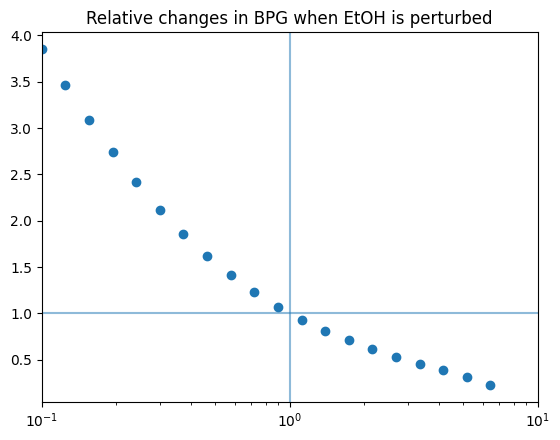

In [140]:
plt.scatter(EtOH_scale, calculate_relative_change('BPG'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in BPG when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

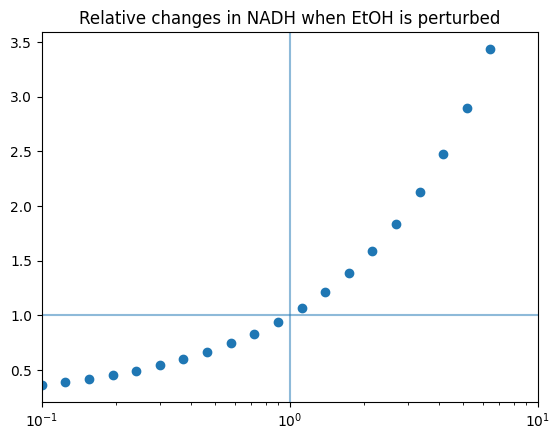

In [141]:
plt.scatter(EtOH_scale, calculate_relative_change('NADH'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in NADH when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

Solving equation 10 of Smallbone et al. which is what gives the intracellular steady state concentrations. 

However, in order to solve for equation 10, we must first solve for equation 6. 

In [12]:
data = data.iloc[np.arange(1).repeat(2)]

In [13]:
# solving for equation 6 


In [46]:
ref_ind = data.idxmax()['ETOH']
x = data[s.getFloatingSpeciesIds()]
x_star = x.iloc[ref_ind].values
y = data[s.getBoundarySpeciesIds()]
y_star = y.iloc[ref_ind].values
y_star[y_star == 0] = 1e-6
yn = y.divide(y_star).reset_index()
yn.drop(yn.index[ref_ind], inplace=True)
yn.drop(['index'], axis=1, inplace=True)
yn[yn == 0] = 1E-6

In [7]:
squiggle_idx = [1,2,3,4,5]
N = s.getFullStoichiometryMatrix()
N[squiggle_idx,:]

 [[ 1, -1, -1, -2,  0,  0,  0,  0, 0, 0, 0, 0, 0, 0, 0,  0, 0],
  [ 0,  1,  0,  0, -1,  0,  0,  0, 0, 0, 0, 0, 0, 0, 0,  0, 0],
  [ 0,  0,  0,  0,  1, -1,  0,  0, 0, 0, 0, 0, 0, 0, 0,  0, 0],
  [ 0,  0,  0,  0,  0,  2, -1,  0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
  [ 0,  0,  0,  0,  0,  0,  1, -1, 0, 0, 0, 0, 0, 0, 0,  0, 0]]

In [17]:
t1 = np.linalg.inv(np.diag(x_star))
t2 = np.linalg.inv(np.diag(np.ones(len(x_star))))
t3 = BIOMD64.N
t4 = np.linalg.pinv(BIOMD64.N[:-1,:])
t5 = np.diag(np.ones(len(squiggle_idx)))
t6 = np.diag(x_star[squiggle_idx])